# Imports

In [1]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [2]:
import os
import logging
import sys
import inspect
from copy import copy

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import itertools
import pandas as pd
import random
import optuna
from optuna.trial import TrialState
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as dist
import torch.optim as optim
from torch.optim import Adam, RMSprop
import torch.utils.data
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import utils.models as m
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut

import utils.h5_utils as h5
from utils.constants import DATA_PATH, N_CHANNELS, CENTRAL_RANGE, BATCH_SIZE, LABELLING, CORRESPONDENCE
from pathlib import Path
from npyx.feat import temporal_features
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/npyx/miniconda3/envs/npyx/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


npyx version 2.5.2 imported.


In [3]:
PATH = os.path.dirname(os.path.abspath(""))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CLASSES = 6
DIR = os.getcwd()
BASE_DATASET = h5.NeuronsDataset(DATA_PATH, quality_check=True, normalise=False)
BASE_DATASET.min_max_scale()
BASE_DATASET.make_full_dataset(wf_only=True)
LABELS_ONLY_DATASET = copy(BASE_DATASET)
LABELS_ONLY_DATASET.make_labels_only()
SEED = 1234
USE_CUDA = torch.cuda.is_available()
TEST_FREQUENCY = 1
BETA = 1

INIT_WEIGHTS = True

h5.set_seed(SEED)
torch.set_default_dtype(torch.float32)

Reading dataset:   0%|          | 0/1213 [00:00<?, ?it/s]

954 neurons loaded, of which labelled: 77 
259 neurons discarded, of which labelled: 7. More details at the 'discarded_df' attribute.
Random seed 1234 has been set.


In [62]:
pd.Series(LABELS_ONLY_DATASET.labels_list).value_counts()

unlabelled    877
GoC            25
PkC_ss         21
PkC_cs         11
MFB             9
GrC             6
MLI             5
dtype: int64

In [4]:
labels = BASE_DATASET.targets
wf_dataset = BASE_DATASET.wf

In [5]:
class CerebellumWFDataset(data.Dataset):
    """Dataset of waveforms as images. Every batch will have shape:
    (batch_size, 1, N_CHANNELS, CENTRAL_RANGE)"""

    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (ndarray): Array of data points
            labels (string): Array of labels for the provided data
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data_point = (
            self.data[idx, :].astype("float32").reshape(1, N_CHANNELS, CENTRAL_RANGE)
        )
        label = self.labels[idx].astype("int")

        sample = (data_point, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class Encoder(nn.Module):
    def __init__(self, encoder, d_latent):
        super().__init__()
        self.encoder = encoder.float()
        self.d_latent = d_latent

    def forward(self, x):
        # flatten the image
        x = x.view(x.shape[0], -1)
        # forward pass through encoder network
        h = self.encoder(x)
        # split the output into mu and log_var
        mu = h[:, : self.d_latent]
        log_var = h[:, self.d_latent :]
        # return mu and log_var
        return dist.Normal(mu, torch.exp(log_var))


class Decoder(nn.Module):
    def __init__(self, decoder, d_latent):
        super().__init__()
        self.decoder = decoder.float()
        self.d_latent = d_latent

    def forward(self, z):
        # flatten the latent vector
        z = z.view(z.shape[0], -1)
        # forward pass through decoder network
        h = self.decoder(z)

        X_hat = h[:, : N_CHANNELS * CENTRAL_RANGE]
        log_sig = h[:, N_CHANNELS * CENTRAL_RANGE :]

        return dist.Normal(
            X_hat.reshape(-1, 1, N_CHANNELS, CENTRAL_RANGE),
            log_sig.reshape(-1, 1, N_CHANNELS, CENTRAL_RANGE).exp(),
        )
def ELBO_VAE(enc, dec, X, beta=1):
    """

    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28).

    """

    batch_size = X.shape[0]
    n_samples = 20  # number of monte carlo samples
    prior = dist.MultivariateNormal(
        loc=torch.zeros(enc.d_latent).to(DEVICE),
        covariance_matrix=torch.eye(enc.d_latent).to(DEVICE),
    )
    ELBO = torch.zeros(batch_size).to(DEVICE)

    for _ in range(n_samples):

        q_z = enc.forward(X)  # q(Z | X)
        z = (
            q_z.rsample()
        )  # Samples from the encoder posterior q(Z | X) using the reparameterization trick
        p_x = dec.forward(z)  # distribution p(x | z)

        log_prior = prior.log_prob(z)  # log( p(z_i) )
        dec_log_likelihood = (
            p_x.log_prob(X).reshape(batch_size, -1).sum(axis=1)
        )  # log( p(x_i | z_i) )
        enc_posterior = q_z.log_prob(z).sum(axis=1)  # log( q(z_i | x_i) )

        # Calculate the ELBO on the whole batch
        ELBO += dec_log_likelihood + beta * (-enc_posterior + log_prior)

    return ELBO / n_samples

In [7]:
def define_model(params=None):
    if params is None:
        best_params = optuna.load_study(
            "true-random-beta_v4", f"sqlite:///{PATH}/true-random-beta_v4.db"
        ).best_params
    else:
        best_params = params

    n_layers = best_params["n_layers"]
    d_latent = best_params["d_latent"]

    in_features = N_CHANNELS * CENTRAL_RANGE

    encoder_layers = []
    decoder_layers = []
    first_units = None

    for i in range(n_layers):
        out_features = best_params[f"n_units_l{i}"]
        p = best_params[f"dropout_l{i}"]
        if i == 0:
            first_units = out_features

        # Create and properly init encoder layer
        cur_enc_layer = nn.Linear(in_features, out_features)
        if INIT_WEIGHTS:
            cur_enc_layer.weight.data.normal_(0, 0.001)
            cur_enc_layer.bias.data.normal_(0, 0.001)

        # Create and properly init decoder layer
        cur_dec_layer = nn.Linear(out_features, in_features)
        if INIT_WEIGHTS:
            cur_dec_layer.weight.data.normal_(0, 0.001)
            cur_dec_layer.bias.data.normal_(0, 0.001)

        encoder_layers.append(cur_enc_layer)
        decoder_layers.append(cur_dec_layer)

        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Dropout(p))

        encoder_layers.append(nn.Dropout(p))
        decoder_layers.append(nn.ReLU())

        in_features = out_features
    encoder_layers.append(nn.Linear(in_features, d_latent))
    decoder_layers.append(nn.Linear(d_latent, in_features))

    encoder = nn.Sequential(*encoder_layers[:-1], nn.Linear(in_features, 2 * d_latent))
    decoder = nn.Sequential(
        *decoder_layers[:0:-1], nn.Linear(first_units, 2 * (N_CHANNELS * CENTRAL_RANGE))
    )

    encoder = Encoder(encoder, d_latent)
    decoder = Decoder(decoder, d_latent)

    return encoder.to(DEVICE), decoder.to(DEVICE)

# Loading or training the encoder

In [8]:
LOAD = True
OLD = False

In [9]:
h5.set_seed(SEED)
best_params = optuna.load_study(
            "true-random-beta_v4", f"sqlite:///{PATH}/true-random-beta_v4.db"
        ).best_params

# best_params = {'beta': 5,
#     'd_latent': 10,
#     'dropout_l0': 0.1,
#     'dropout_l1': 0.1,
#     'lr': 0.001,
#     'n_layers': 2,
#     'n_units_l0': 200,
#     'n_units_l1': 100,
#     'optimizer': 'Adam',
#     'batch_size': 50}

if LOAD and not OLD:
    wvf_enc, wvf_dec = define_model()

    wvf_enc.load_state_dict(torch.load(f"{PATH}/best_enc_v4.pt", map_location=DEVICE))
    wvf_dec.load_state_dict(torch.load(f"{PATH}/best_dec_v4.pt", map_location=DEVICE))

    wvf_enc.eval()
    wvf_dec.eval()
    
    tmp_features = []
    for spikes in tqdm(LABELS_ONLY_DATASET.spikes_list):
        tmp_features.append(temporal_features(spikes))

    wvf_features = []
    for wf in tqdm(LABELS_ONLY_DATASET.wf):
        wf_tensor = (
            torch.tensor(wf, dtype=torch.float32)
            .to(DEVICE)
            .reshape(1, 1, N_CHANNELS, CENTRAL_RANGE)
        )
        with torch.no_grad():
            enc_features = wvf_enc(wf_tensor).mean.detach().cpu().numpy().ravel()
        wvf_features.append(enc_features)
        
elif LOAD and OLD:
    wvf_enc = m.ForwardEncoder(7).to(DEVICE)
    wvf_enc.load_state_dict(torch.load(f"{PATH}/old_encoder_best.pt", map_location=torch.device('cpu')))
    wvf_enc.eval()

    wvf_dec = m.ForwardDecoder(7).to(DEVICE)
    wvf_dec.load_state_dict(torch.load(f"{PATH}/old_decoder_best.pt", map_location=torch.device('cpu')))
    wvf_dec.eval()
    
    tmp_features = []
    for spikes in tqdm(LABELS_ONLY_DATASET.spikes_list):
        tmp_features.append(temporal_features(spikes))

    wvf_features = []
    for wf in tqdm(LABELS_ONLY_DATASET.wf):
        wf_tensor = (
            torch.tensor(wf, dtype=torch.float32)
            .to(DEVICE)
            .reshape(1, 1, N_CHANNELS, CENTRAL_RANGE)
        )
        with torch.no_grad():
            enc_features = wvf_enc(wf_tensor).mean.detach().cpu().numpy().ravel()
        wvf_features.append(enc_features)
        
else:
    h5.set_seed(SEED)
    torch.cuda.empty_cache()
    enc, dec = define_model(best_params)

    BATCH_SIZE = best_params["batch_size"]
    # Add augmentation transforms if wanted
    labels = BASE_DATASET.targets
    wf_dataset = BASE_DATASET.wf

    # Add augmentation transforms if wanted
    composed = transforms.Compose([m.VerticalReflection(p=0.3), m.SwapChannels(p=0.5)])
    cerebellum_dataset = CerebellumWFDataset(wf_dataset, labels, transform=composed)
    train_loader = data.DataLoader(cerebellum_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    optimizer_name = best_params["optimizer"]
    lr = best_params["lr"]
    optim_args = {
        "params": itertools.chain(enc.parameters(), dec.parameters()),
        "lr": lr,
    }
    opt_vae = getattr(optim, optimizer_name)(**optim_args)

    # Add a scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(
        opt_vae, milestones=[90, 110, 130], gamma=0.5
    )

    N_epochs = 150
    losses = []

    #! Suggest beta
    beta = best_params["beta"]

    for epoch in tqdm(range(N_epochs), desc="Epochs"):
        train_loss = 0.0
        for (X, _) in train_loader:
            X = X.to(DEVICE)
            opt_vae.zero_grad()
            loss = -ELBO_VAE(enc, dec, X, beta=beta).mean()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(cerebellum_dataset)
        scheduler.step()
        losses.append(train_loss)

    enc.eval()
    dec.eval()
    
    tmp_features = []
    for spikes in tqdm(LABELS_ONLY_DATASET.spikes_list):
        tmp_features.append(temporal_features(spikes))

    wvf_features = []
    for wf in tqdm(LABELS_ONLY_DATASET.wf):
        wf_tensor = (
            torch.tensor(wf, dtype=torch.float32)
            .to(DEVICE)
            .reshape(1, 1, N_CHANNELS, CENTRAL_RANGE)
        )
        with torch.no_grad():
            enc_features = enc(wf_tensor).mean.detach().cpu().numpy().ravel()
        wvf_features.append(enc_features)

wf_dataset = np.stack(wvf_features, axis=0)
tmp_dataset = np.stack(tmp_features, axis=0)

X = np.concatenate((wf_dataset, tmp_dataset), axis=1)
nan_mask = np.isnan(X).any(axis=1)
X = X[~nan_mask]
y = LABELS_ONLY_DATASET.targets[~nan_mask]


Random seed 1234 has been set.


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [10]:
print(f"Running with a wvf encoder with latent dimension {best_params['d_latent']}")

Running with a wvf encoder with latent dimension 10


In [11]:
N_LOOS = 50

In [12]:
h5.set_seed(SEED)
forest_params = optuna.load_study(
    "random-forest-feat-eng", f"sqlite:///{PATH}/random-forest-feat-eng.db"
).best_params


f1_scores = []
confusions_list = []

for loo in tqdm(range(N_LOOS), position = 0, leave = True, desc = "Random Forest runs"):
    
    train_accuracies = []
    true_targets = []
    model_pred = []
    validation_accuracies = []
    
    seed = np.random.choice(2**32)
    
    kfold = LeaveOneOut()
    
    for fold, (train_idx, val_idx) in tqdm(
        enumerate(kfold.split(X, y)),
        leave=False,
        position=1,
        desc="Cross-validating",
        total=len(X),
    ):

        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[val_idx]
        y_test = y[val_idx]

        oversample = RandomOverSampler(random_state=seed)

        X_big, y_big = oversample.fit_resample(X_train, y_train)

        model = RandomForestClassifier(**forest_params, random_state=seed)

        # fit the model on the data
        model.fit(X_big, y_big)
        pred = model.predict(X_test)
        train_accuracies.append(model.score(X_train, y_train))

        true_targets.append(y_test)
        model_pred.append(pred)
        
    confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
    confusions_list.append(confusion)
    
    f1 = f1_score(true_targets, model_pred, average='macro')
    f1_scores.append(f1)
    
    accuracy = (np.array(true_targets) == np.array(model_pred)).mean()
    validation_accuracies.append(accuracy)



mean_train = np.array(train_accuracies).mean()
mean_validation = np.array(validation_accuracies).mean()
print(
f"Mean train accuracy is {mean_train:.3f} while LOO accuracy is {mean_validation:.3f}"
)
print(f"Mean LOO f1 score across random forests is {np.array(f1_scores).mean():.3f}")


Random seed 1234 has been set.


Random Forest runs:   0%|          | 0/50 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/76 [00:00<?, ?it/s]

Mean train accuracy is 0.955 while LOO accuracy is 0.711
Mean LOO f1 score across random forests is 0.638


In [13]:
# 0.638 and 0.711 for the LOO f1 score and accuracy respectively

In [14]:
np.std(np.array(f1_scores))

0.03580544766112959

In [15]:
np.array(train_accuracies).std()

0.0098417768966707

In [16]:
max(f1_scores)

0.7037294763263199

In [17]:
print(best_params)

{'batch_size': 69, 'beta': 4.63, 'd_latent': 10, 'dropout_l0': 0.47, 'lr': 0.00164022900982639, 'n_layers': 1, 'n_units_l0': 86, 'optimizer': 'Adam'}


# Confusion matrix

In [18]:
mean_confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
mean_confusion = mean_confusion / (np.sum(mean_confusion, axis = 0)) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

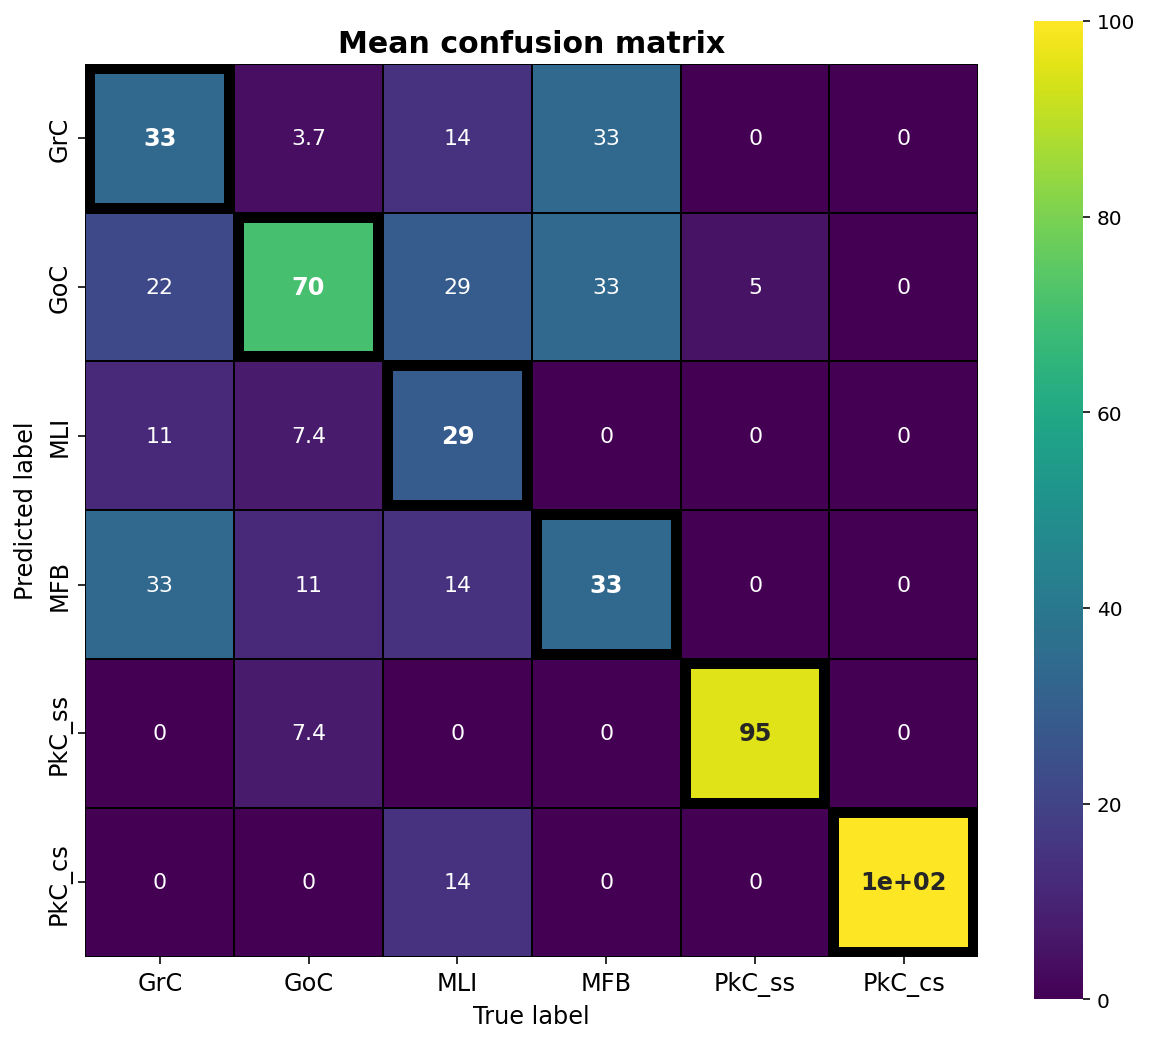

In [19]:
# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=False,
    mask=mask,
    linewidths=10,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    square=True,
    vmin=0,
    vmax=100,
    mask=~mask,
    linewidths=1,
    linecolor="black",
    annot_kws={"fontsize": 11},
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);


# Latent space visualisation

In [20]:
def plot_random_reconstruction(full_dataset, enc, dec, dataset_info, n_neurons=1, label=None):
    """
    Plots a random neuron from the dataset. Optionally, can specify a label
    """
    if label is not None:
        if label in CORRESPONDENCE:
            mask = full_dataset[:, 0] == label
            full_dataset = full_dataset[mask, :]
        elif label in LABELLING:
            mask = full_dataset[:, 0] == LABELLING[label]
            full_dataset = full_dataset[mask, :]
        else:
            return "Invalid label"
        
    if n_neurons > full_dataset.shape[0]:
        print(f"Only {full_dataset.shape[0]} neurons to plot with the provided parameter choice")
        n_neurons = full_dataset.shape[0]
        
    idx = np.random.choice(range(full_dataset.shape[0]), n_neurons, replace = False)
    for i in idx:
        fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
        fig.suptitle(
            r"$\bf{"
            + CORRESPONDENCE[full_dataset[i, 0]]
            + "}$ - "
            + "Dataset: "
            + dataset_info[i]
        )
        wf_original = full_dataset[i, 1:].reshape(
            N_CHANNELS, CENTRAL_RANGE
        )
        
        axs[0,0].imshow(wf_original, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            CENTRAL_RANGE - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        
        axs[0,0].add_patch(rect)
        axs[0,0].set_title("Original raw waveform across channels")
        
        n_lines = wf_original.shape[0]
        x = range(wf_original.shape[1])
        linewidth = 4
        for j, row in enumerate(wf_original):
            if j == 5:
                line = row + (n_lines - j)
                axs[0,1].plot(x, line, lw=linewidth, c = "red", alpha=1, zorder=j/n_lines)
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - j)
                axs[0,1].plot(x, line, lw=linewidth, c = "grey", alpha=1, zorder=j/n_lines)
        axs[0,1].set_title("Original Raw waveforms")
        axs[0,1].set_yticks([])
        
        axs[0,2].plot(wf_original[N_CHANNELS // 2, :])
        axs[0,2].set_title("Original Peak channel waveform")
        
        with torch.no_grad():
            network_input = torch.Tensor(full_dataset[i, 1:].reshape(1, 1, N_CHANNELS, CENTRAL_RANGE).astype(np.float32))
            wf_reconstructed = dec(enc(network_input).sample()).mean.reshape(N_CHANNELS, CENTRAL_RANGE).detach().numpy()
            reconstructed_stddev = dec(enc(network_input).sample()).stddev.reshape(N_CHANNELS, CENTRAL_RANGE).detach().numpy()
        
        axs[1,0].imshow(wf_reconstructed, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            CENTRAL_RANGE - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        
        axs[1,0].add_patch(rect)
        axs[1,0].set_title("Reconstructed raw waveform across channels")
        
        n_lines = wf_reconstructed.shape[0]
        x = range(wf_reconstructed.shape[1])
        linewidth = 4
        for i, row in enumerate(wf_reconstructed):
            if i == 5:
                line = row + (n_lines - i)
                axs[1,1].plot(x, line, lw=linewidth, c = "red", alpha=1, zorder=i/n_lines)
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - i)
                axs[1,1].plot(x, line, lw=linewidth, c = "grey", alpha=1, zorder=i/n_lines)
        axs[1,1].set_title("Reconstructed Raw waveforms")
        axs[1,1].set_yticks([])
        
        axs[1,2].plot(wf_reconstructed[N_CHANNELS // 2, :])
        axs[1,2].set_title("Reconstructed Peak channel waveform")
        axs[1,2].fill_between(
            range(wf_reconstructed.shape[1]),
            wf_reconstructed[N_CHANNELS // 2, :] + reconstructed_stddev[N_CHANNELS // 2, :],
            wf_reconstructed[N_CHANNELS // 2, :] - reconstructed_stddev[N_CHANNELS // 2, :],
            facecolor="blue",
            alpha=0.2,
        )

        plt.show()

In [21]:
try:
    enc = wvf_enc.eval().cpu()
    dec = wvf_dec.eval().cpu()
except NameError:
    enc = enc.eval().cpu()
    dec = dec.eval().cpu()


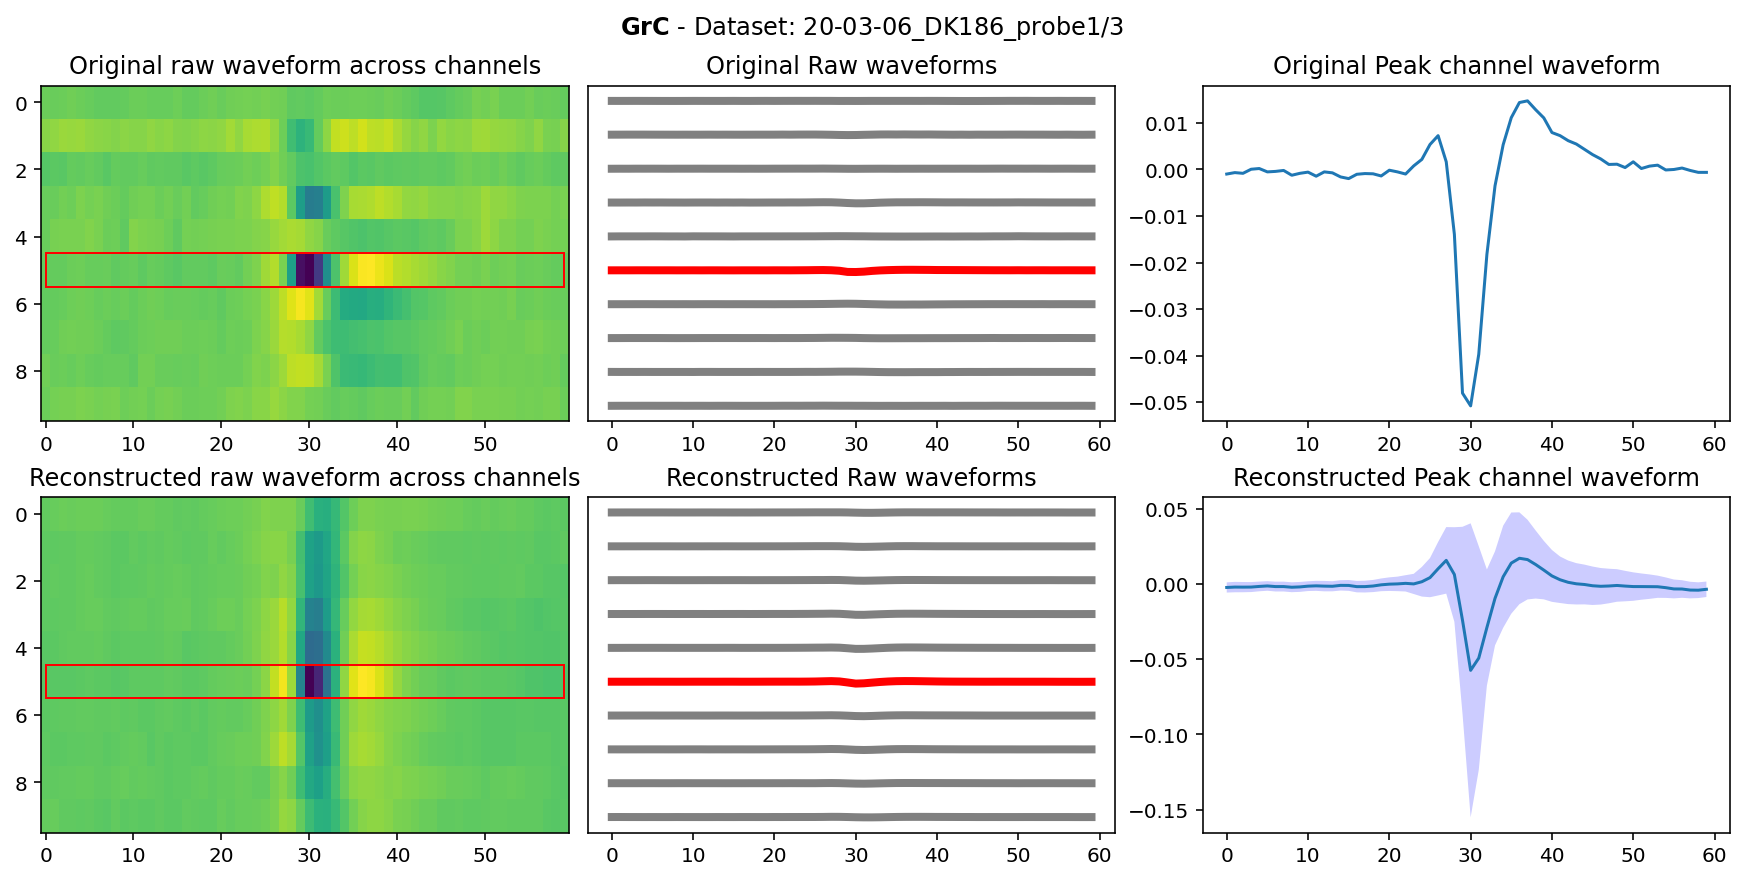

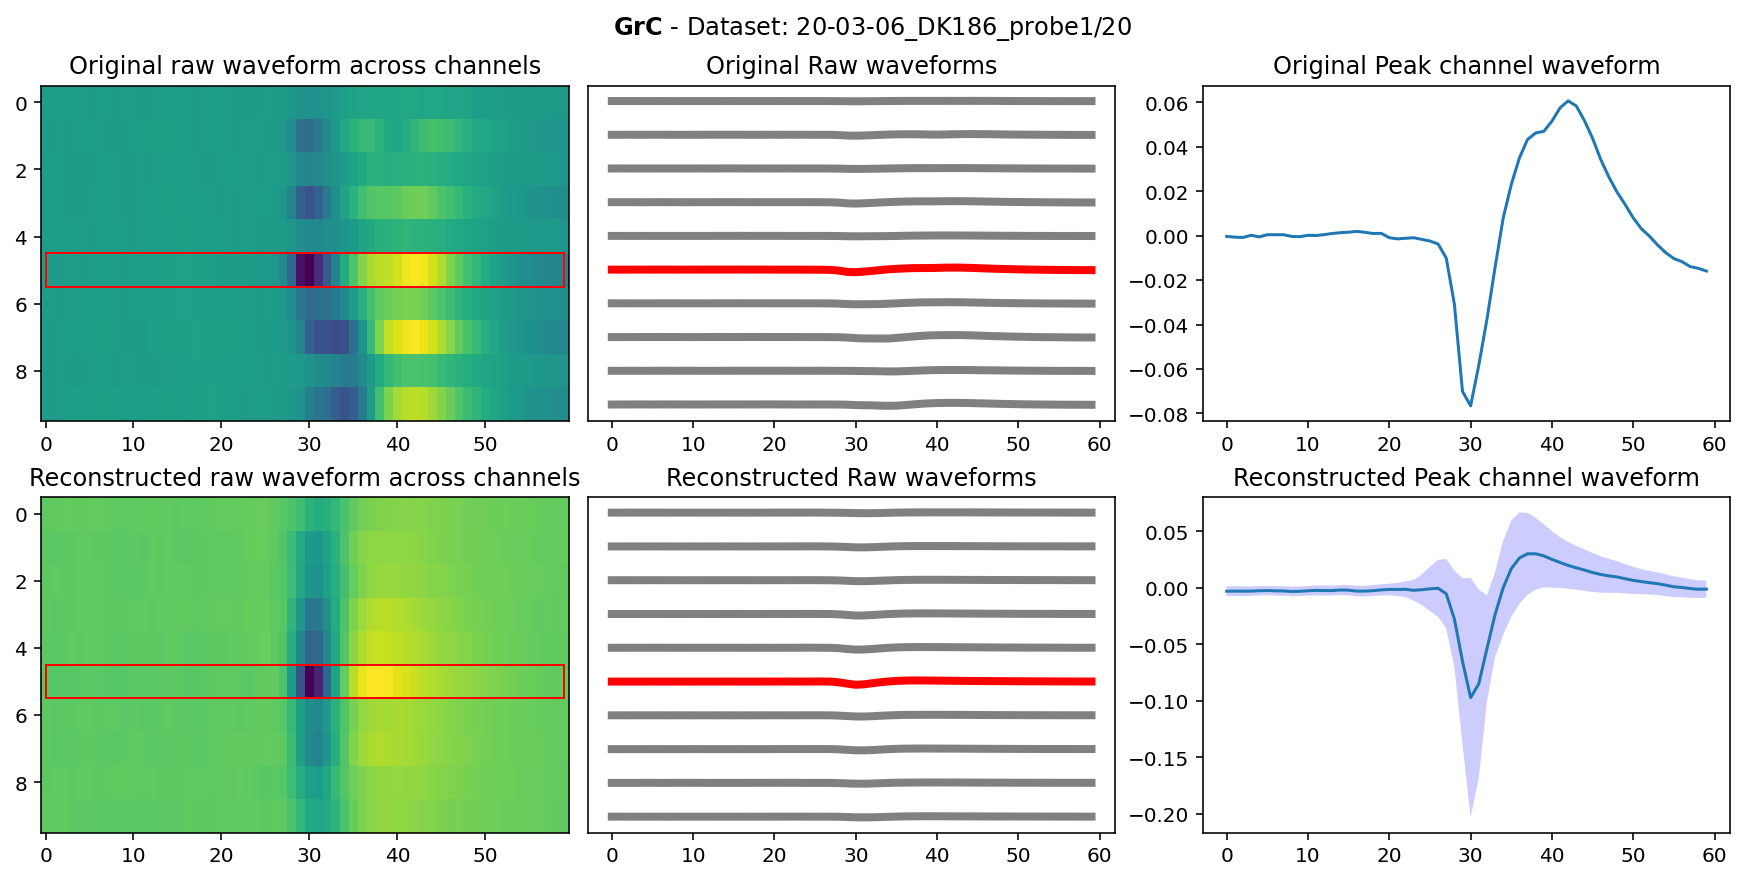

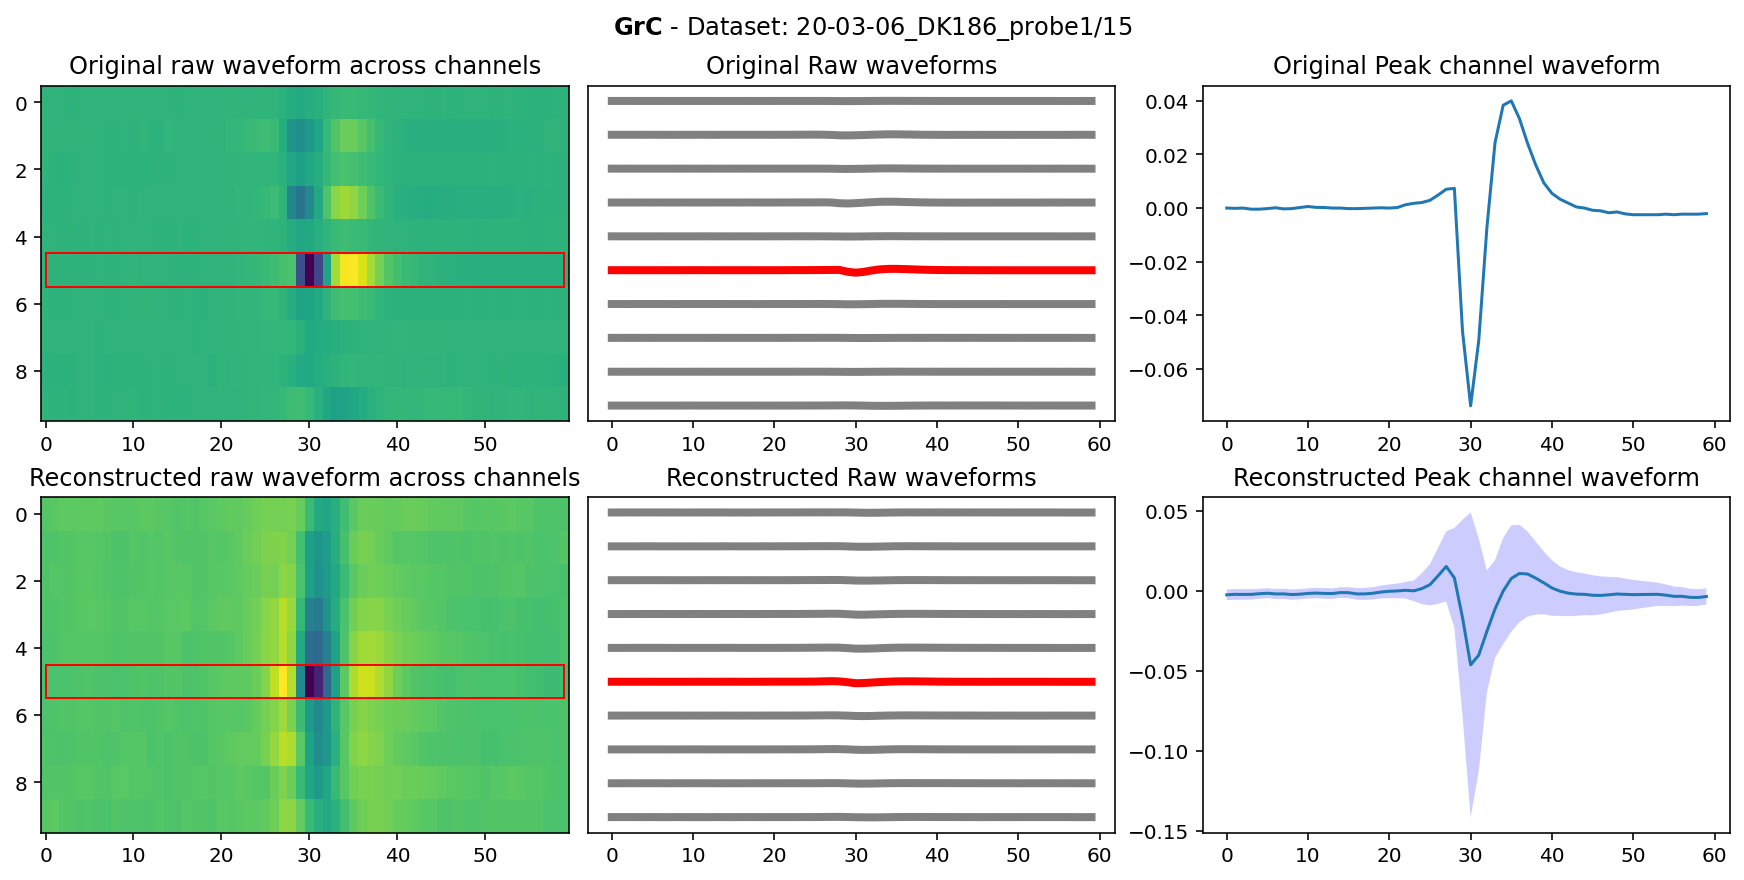

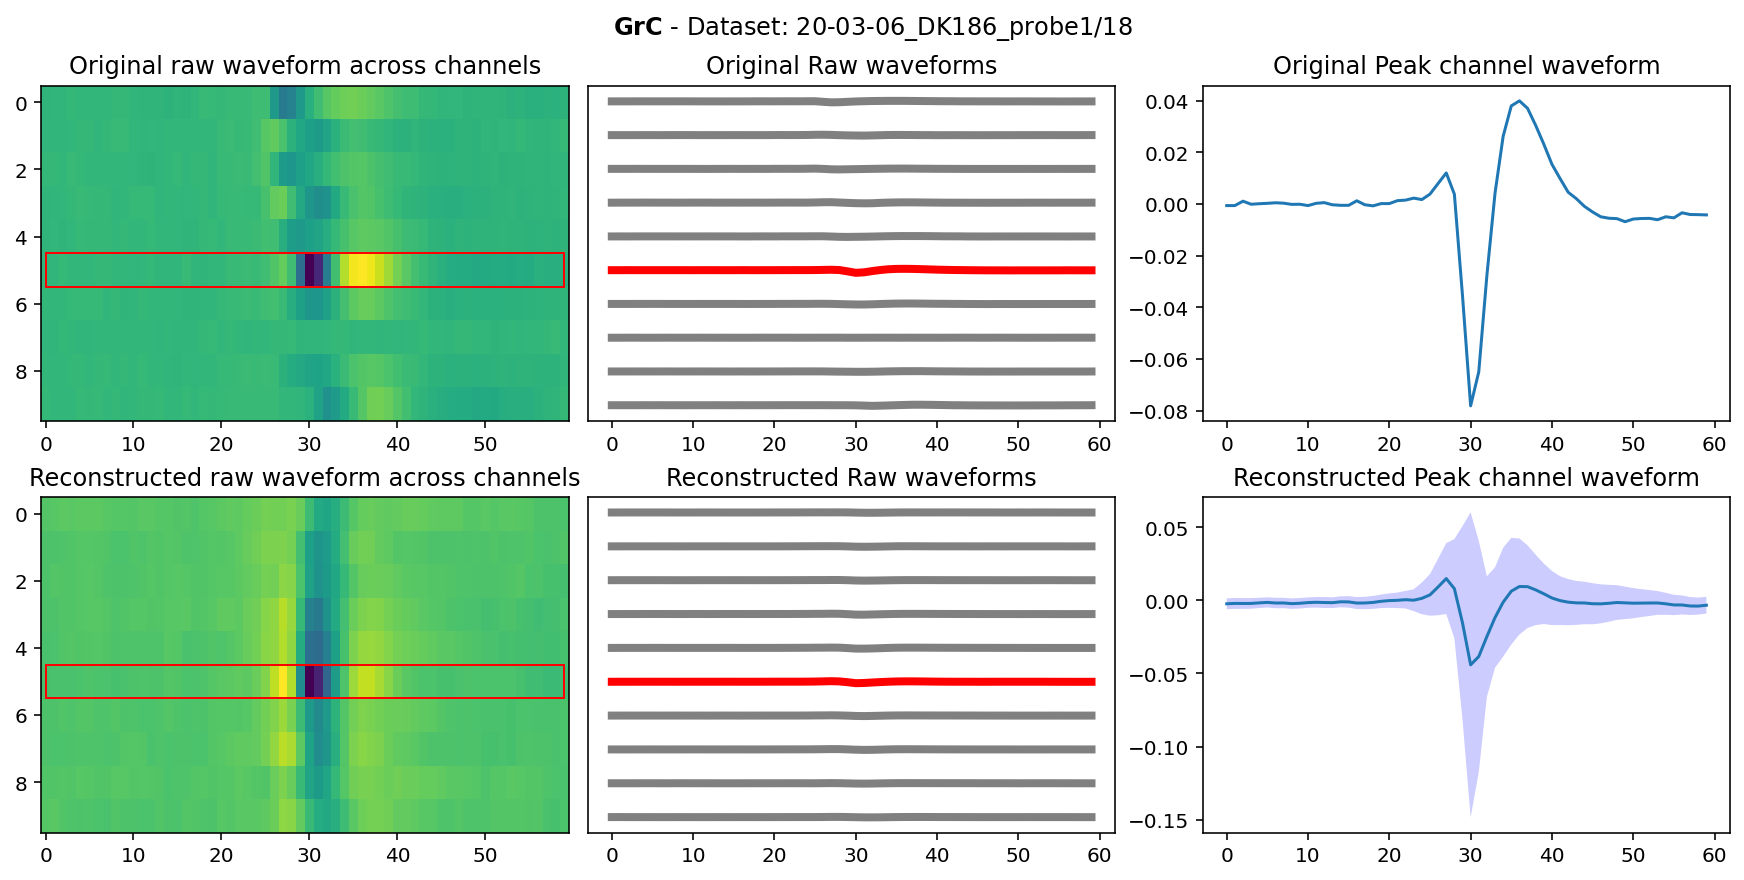

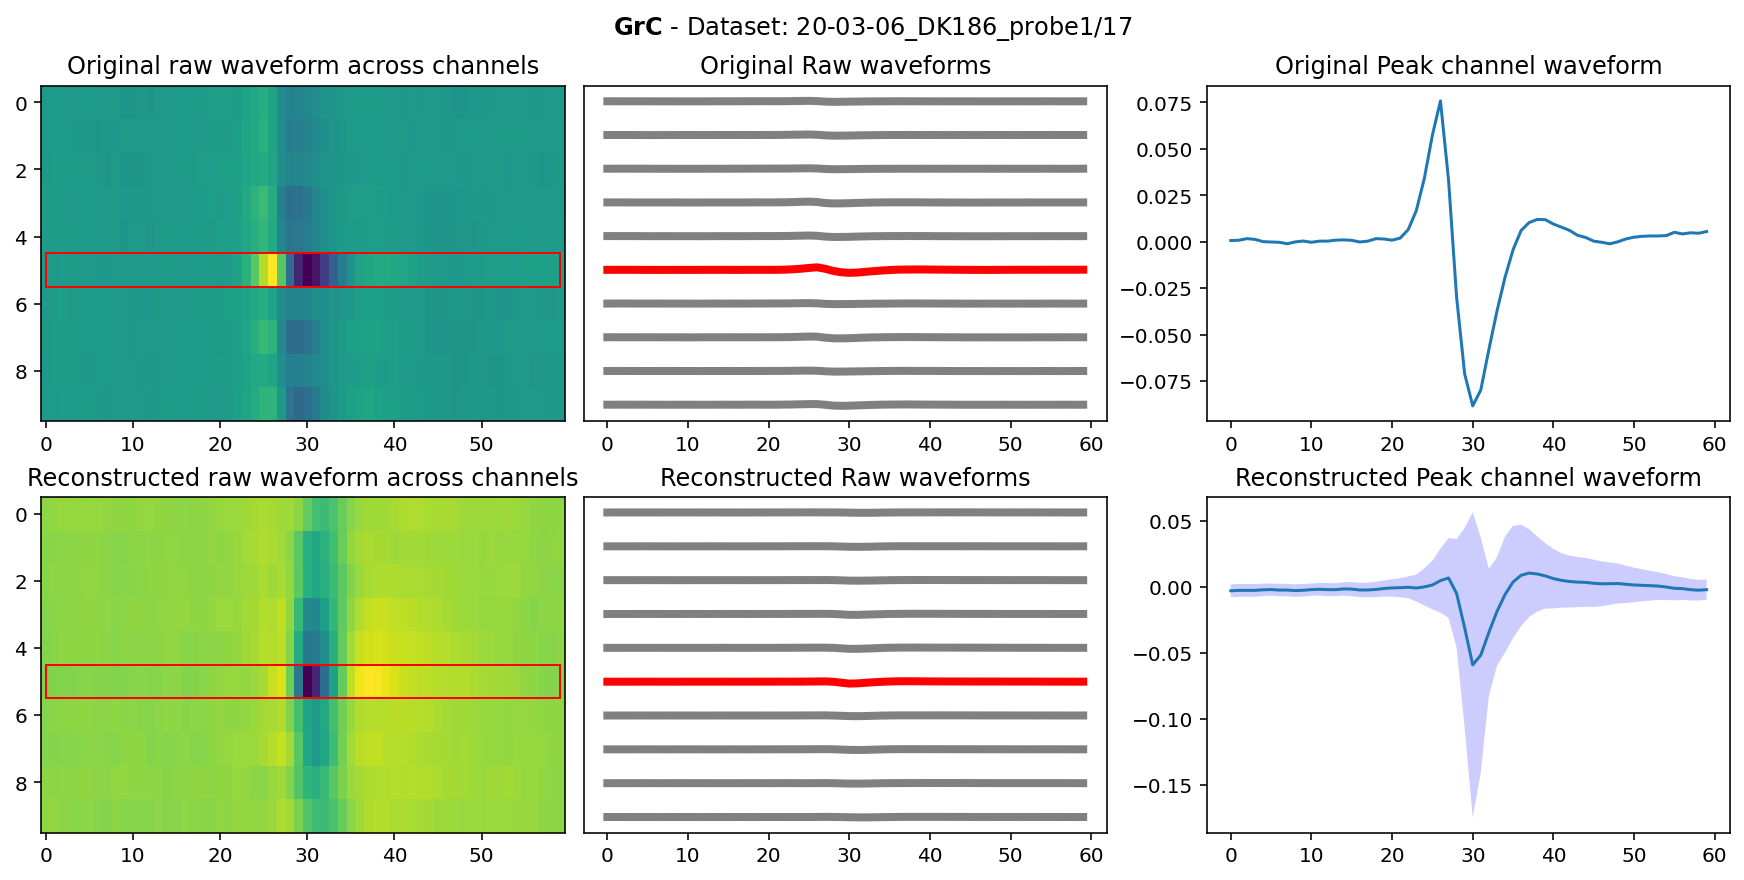

In [22]:
full_dataset = np.concatenate((BASE_DATASET.targets[:, None], BASE_DATASET.wf), axis=1)
dataset_info = BASE_DATASET.info

plot_random_reconstruction(full_dataset, enc, dec, dataset_info, n_neurons=5, label="GrC")


In [23]:
plotting_dataset = CerebellumWFDataset(LABELS_ONLY_DATASET.wf, LABELS_ONLY_DATASET.targets)
plotting_train_loader = data.DataLoader(plotting_dataset, batch_size=len(plotting_dataset))

In [24]:
X_random_batch, y_random_batch = next(iter(plotting_train_loader))

In [27]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

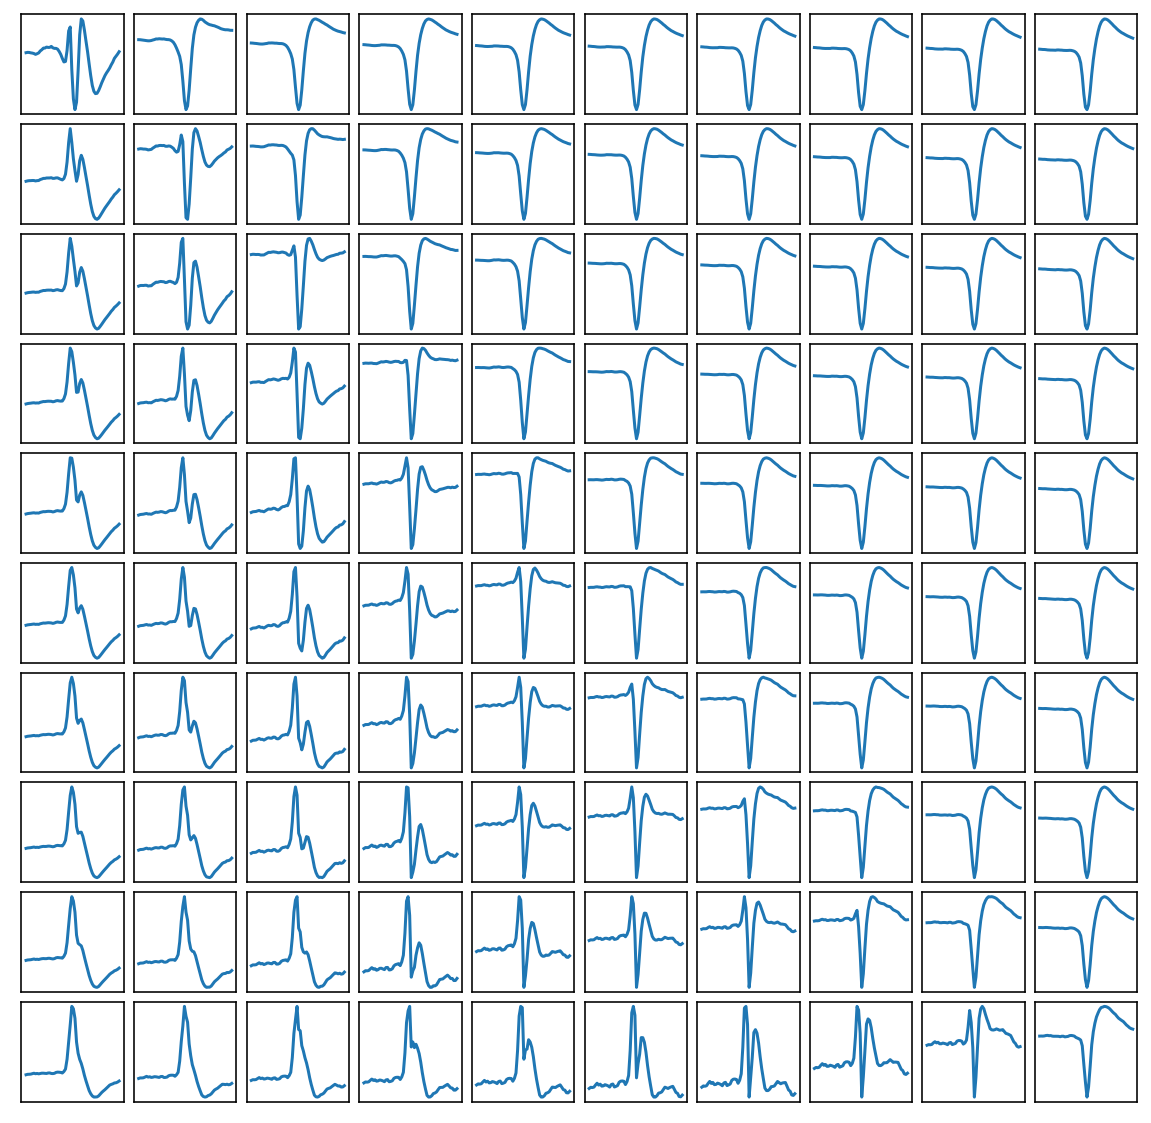

In [70]:
def plot_2d_latent(encoder, decoder, random_batch, n = 15, save=False, std=1, channel=None):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    # Take the first 2 right singular vectors from the SVD of the mean latent space vector over a random batch
    W = torch.linalg.svd(encoder(random_batch).mean).Vh[:2]
    # Take the inverse cdf of n evenly spaced points from 0 to 1
    points = dist.Normal(0, std).icdf(torch.linspace(0.01, 0.99, n))
    # Create a nxn meshgrid with the points
    XX, YY = torch.meshgrid(points, points)
    # Stack the meshgrid, then reshape to 2 x xxyy. Then transpose so final is xxyy x 2
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    # Get the decoder output of W transformed by that matrix. W is 2 x batch_size
    with torch.no_grad():
        out = decoder(XXYY @ W).mean.numpy().squeeze()
    
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(ncols=n, nrows=n, hspace=0.1, wspace=0.1)
    axs = gs.subplots()
    count = 0
    if channel is None:
        channel = N_CHANNELS // 2
    else:
        assert channel in range(0, out.shape[1]), "Channel must be in range 0 to {}".format(out.shape[1])
    for i in range(n):
        for j in range(n):
            axs[i, j].plot(out[count, channel, :])
            axs[i,j].set_yticks([])
            axs[i,j].set_xticks([])
            axs[i,j].label_outer()
            count += 1
    
    if save:
        plt.savefig(f"wvf_latent_space{n}.pdf")
    plt.show()
    

plot_2d_latent(enc, dec, X_random_batch, n=10, std=2, save=False, channel = 5)

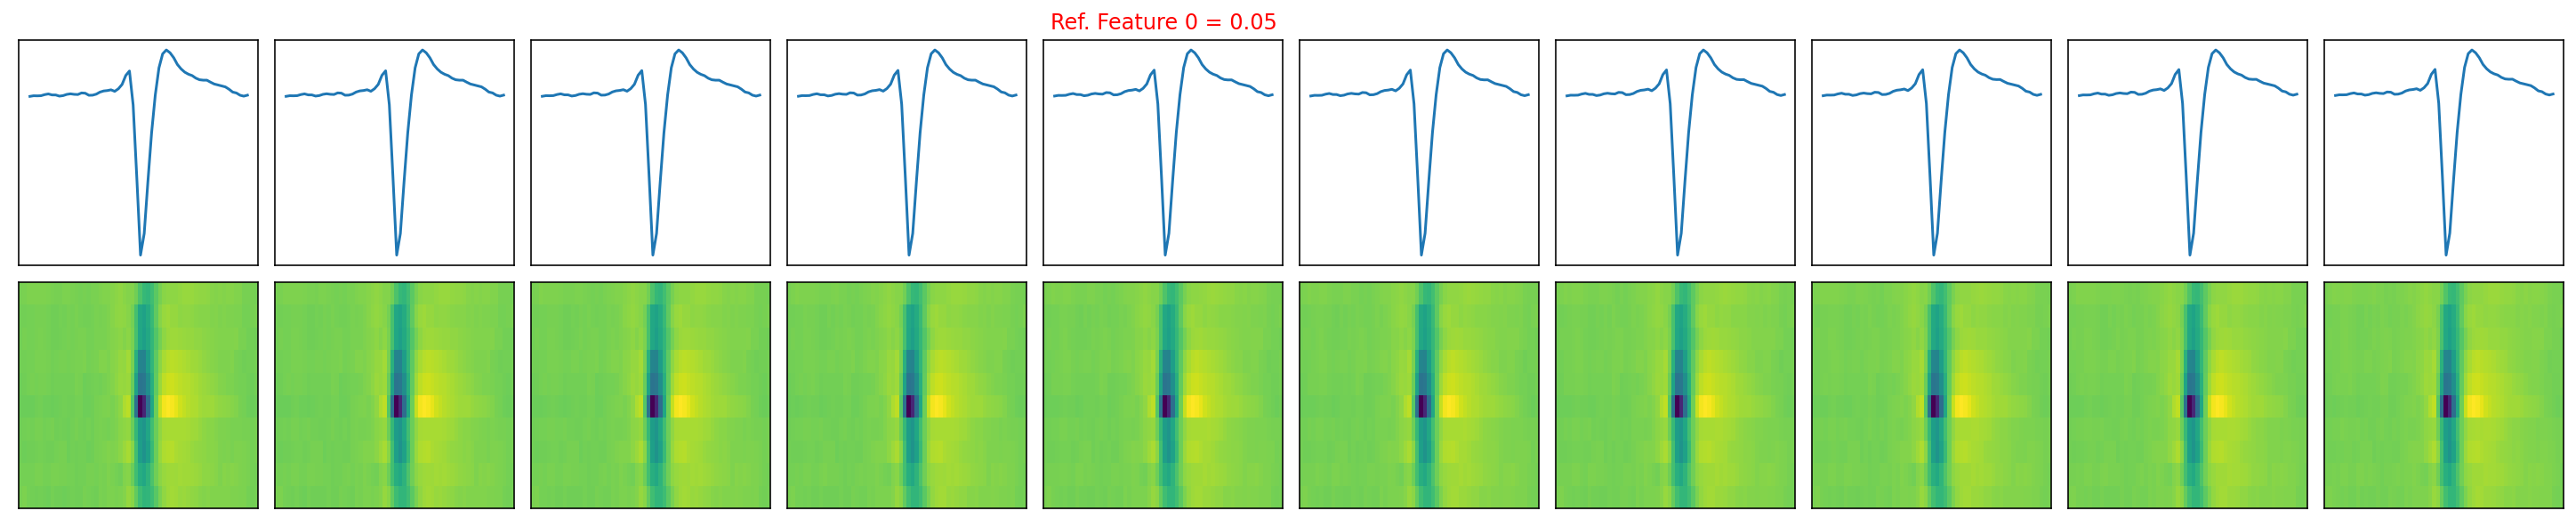

In [40]:
def plot_feature(D_latent, feature_n = 0, n_plots = 10, warmup = None, range_perturbation = 2):
    """ While keeping other feature fixed, creates a range of plots in which
    only feature number n varies in latent space"""
    if warmup is None:
        random_vec = dist.Normal(0, 1).sample((D_latent, ))
    else:
        random_vec = warmup.ravel()
    random_stack = torch.stack([random_vec] * n_plots)
    # Here we create the wanted variation
    random_stack[:, feature_n] = torch.linspace(-range_perturbation, range_perturbation, n_plots)


    fig, axs = plt.subplots(2, n_plots, figsize=(20, 4), constrained_layout=True)
    
    for i, row in enumerate(random_stack):
        if random_vec[feature_n] > row[feature_n] and random_vec[feature_n] < random_stack[i+1][feature_n]:
            with torch.no_grad():
                ref = dec(random_vec.reshape(1, -1)).mean.reshape(N_CHANNELS, CENTRAL_RANGE).numpy()
                
            axs[0,i].plot(ref[N_CHANNELS // 2, :])
            axs[0,i].set_yticks([])
            axs[0,i].set_xticks([])
            axs[0,i].set_title(f"Ref. Feature {feature_n} = {random_vec[feature_n]:.2f}", color='red')
            
            axs[1,i].imshow(ref, interpolation="nearest", aspect="auto")
            axs[1,i].set_yticks([])
            axs[1,i].set_xticks([])
        else:
            with torch.no_grad():
                    out = dec(row.reshape(1, -1)).mean.numpy().squeeze()
            axs[0,i].plot(out[N_CHANNELS // 2, :])
            axs[0,i].set_yticks([])
            axs[0,i].set_xticks([])
            axs[0,i].set_title(f"Feature {feature_n} = {row[feature_n]:.2f}", color="white")
            # axs[0,i].label_outer()
            
            axs[1,i].imshow(out, interpolation="nearest", aspect="auto")
            axs[1,i].set_yticks([])
            axs[1,i].set_xticks([])
            # if i == 0
            # axs[1,i].label_outer()
            
    # TODO add reference image and plot all at once!
            
    plt.show()

d_latent = best_params["d_latent"]
i = 0
network_input = torch.Tensor(full_dataset[i, 1:].reshape(1, 1, N_CHANNELS, CENTRAL_RANGE).astype(np.float32))
warmup_wf = enc(network_input).mean
plot_feature(D_latent = d_latent, feature_n = 0, warmup=warmup_wf)

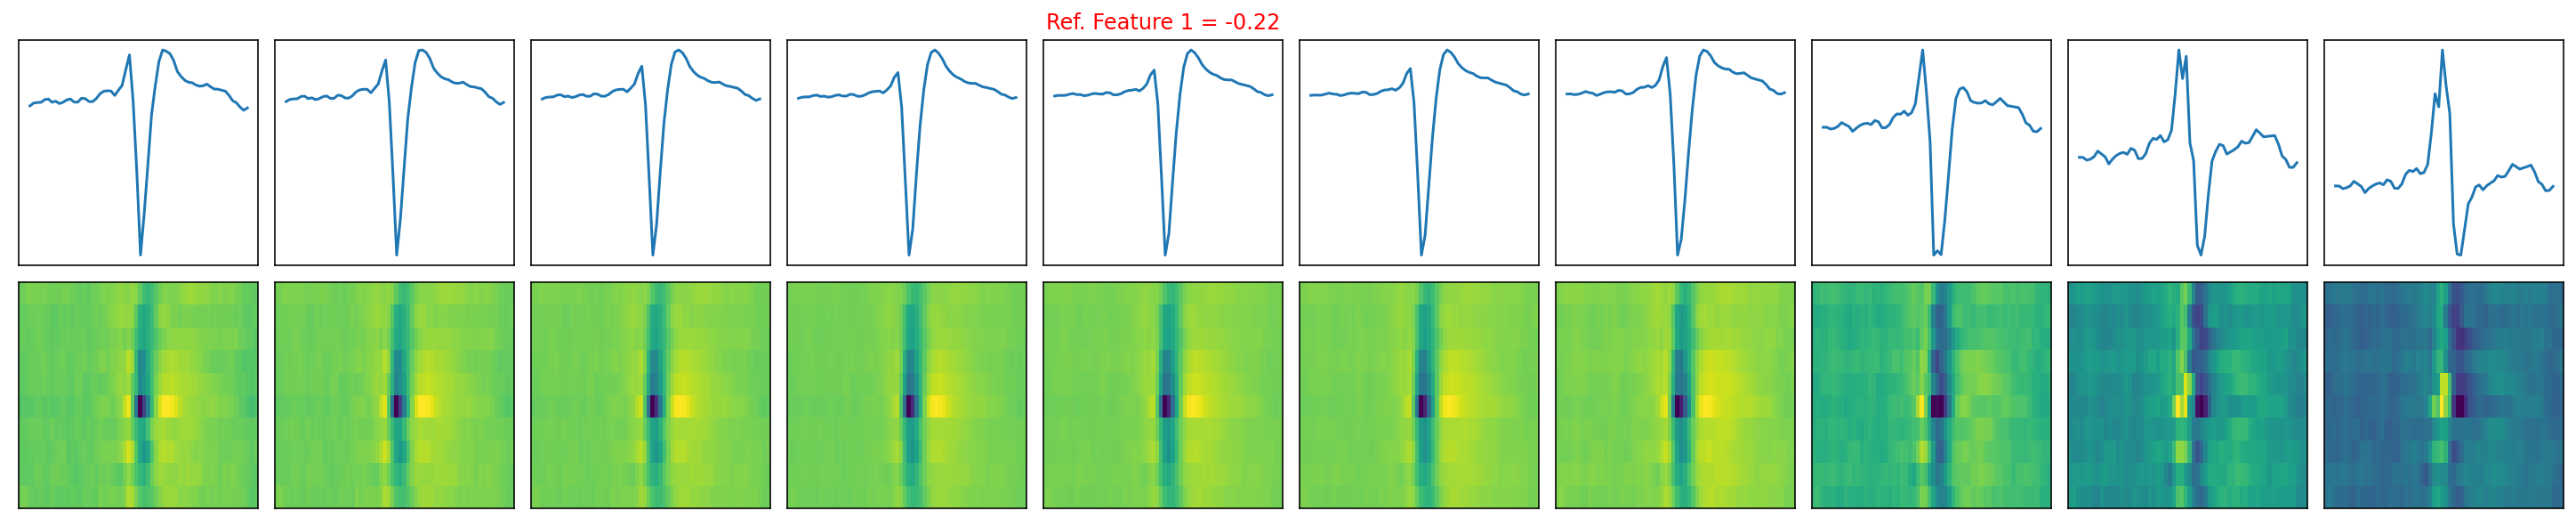

In [43]:
plot_feature(D_latent = d_latent, feature_n = 1, warmup=warmup_wf, range_perturbation=20)

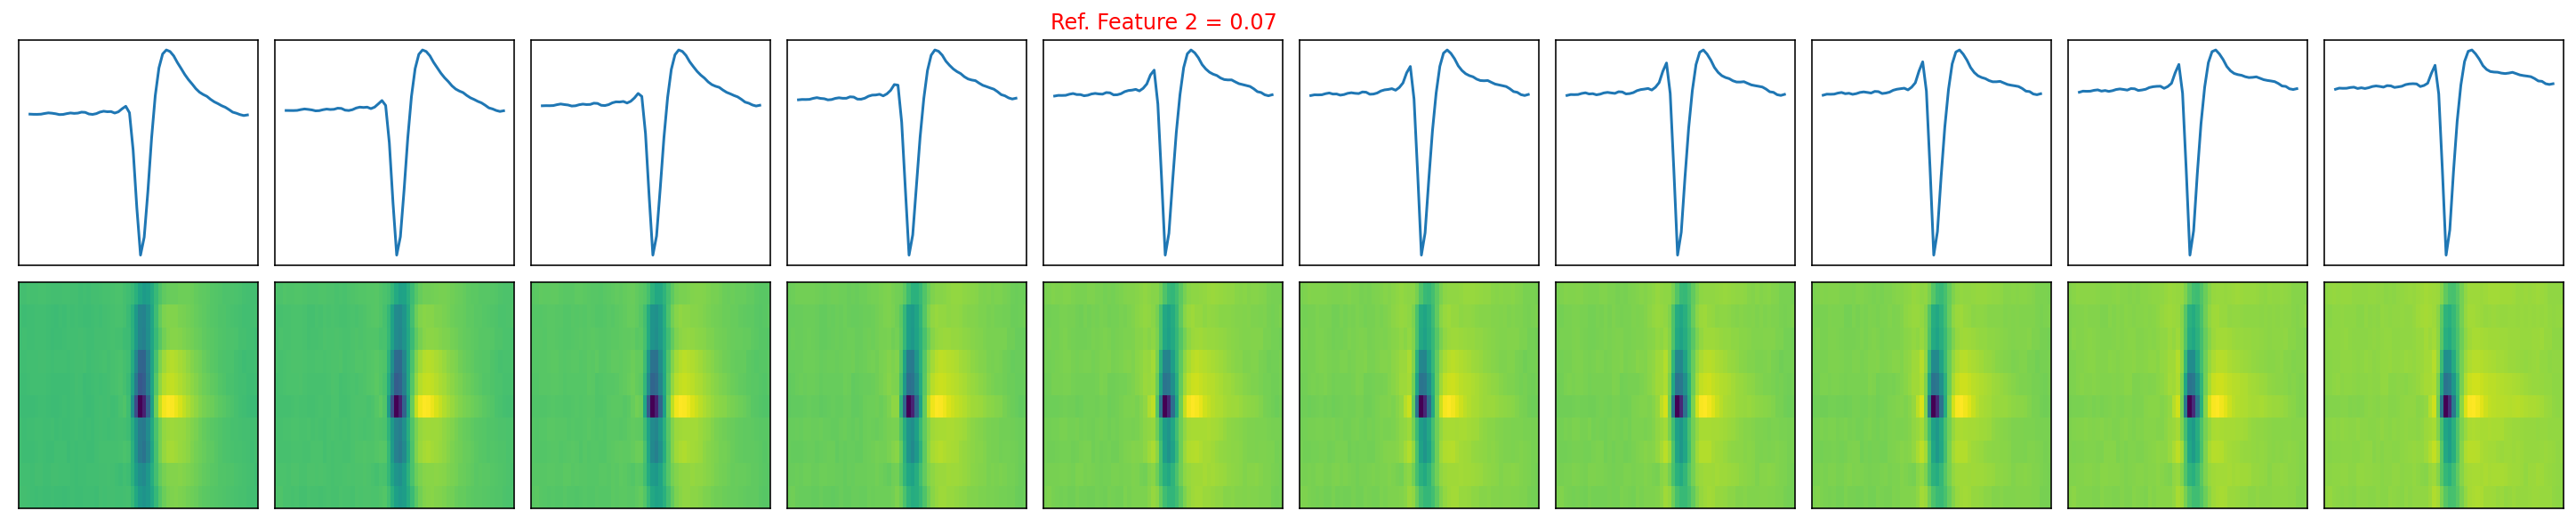

In [46]:
plot_feature(D_latent = d_latent, feature_n = 2, warmup=warmup_wf, range_perturbation=50)

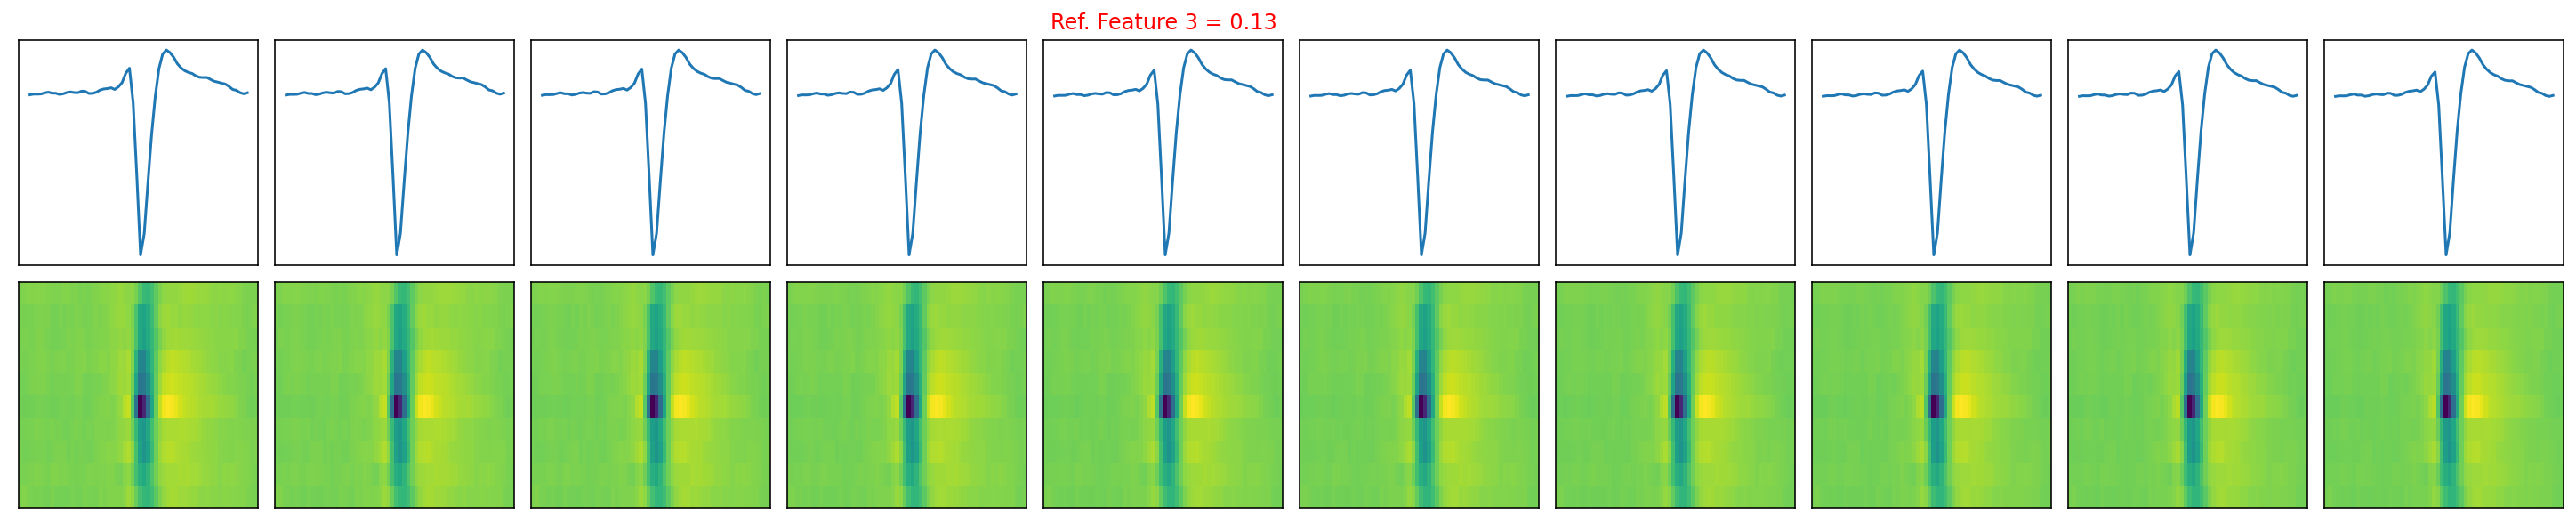

In [ ]:
plot_feature(D_latent = d_latent, feature_n = 3, warmup=warmup_wf)

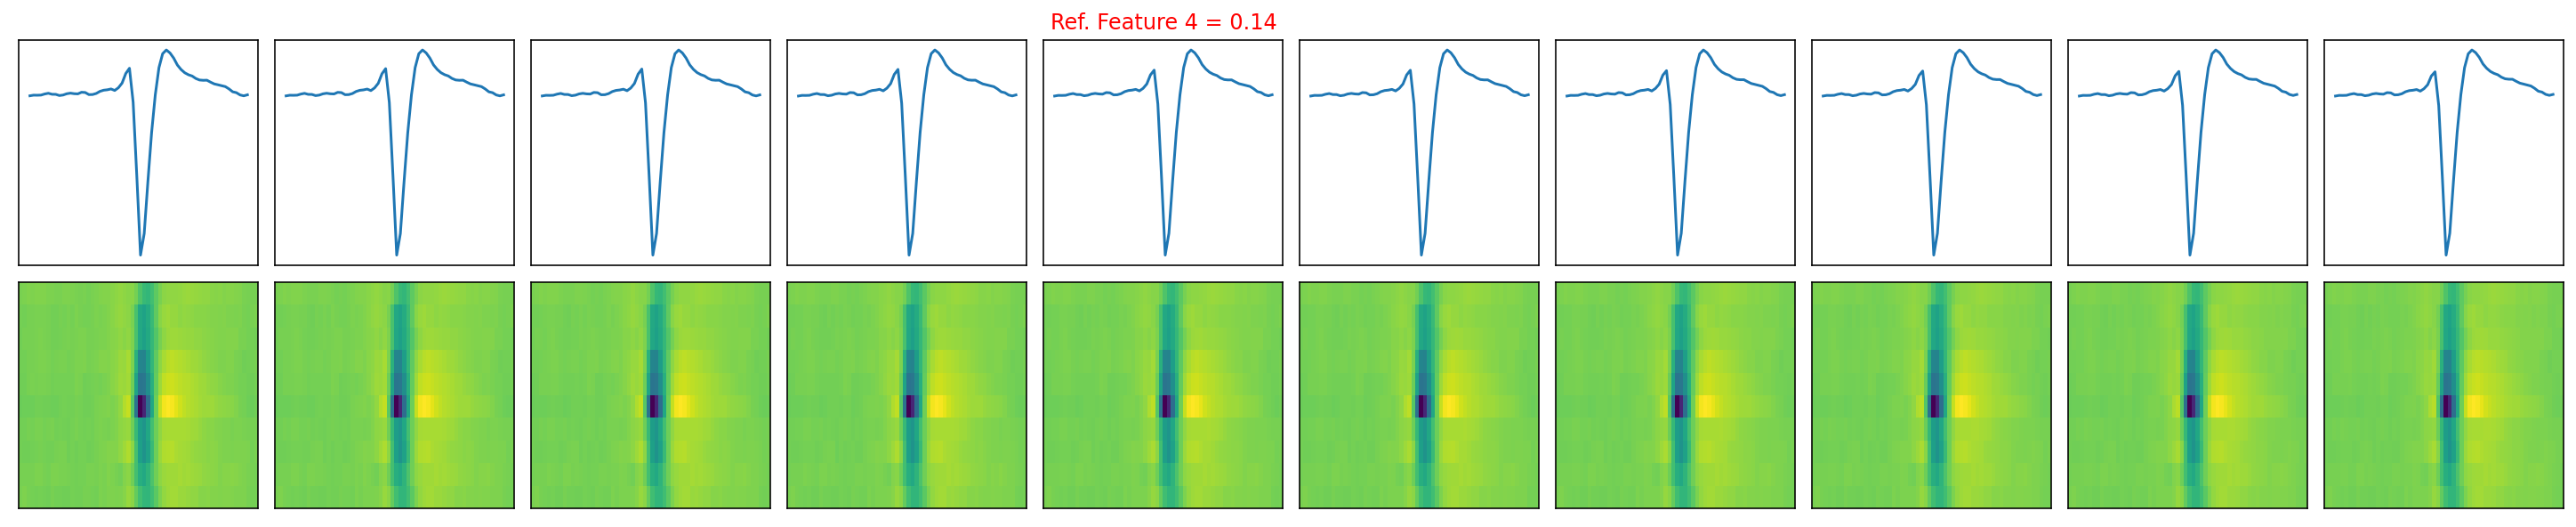

In [ ]:
plot_feature(D_latent = d_latent, feature_n = 4, warmup=warmup_wf)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from pylmnn import LargeMarginNearestNeighbor as LMNN
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

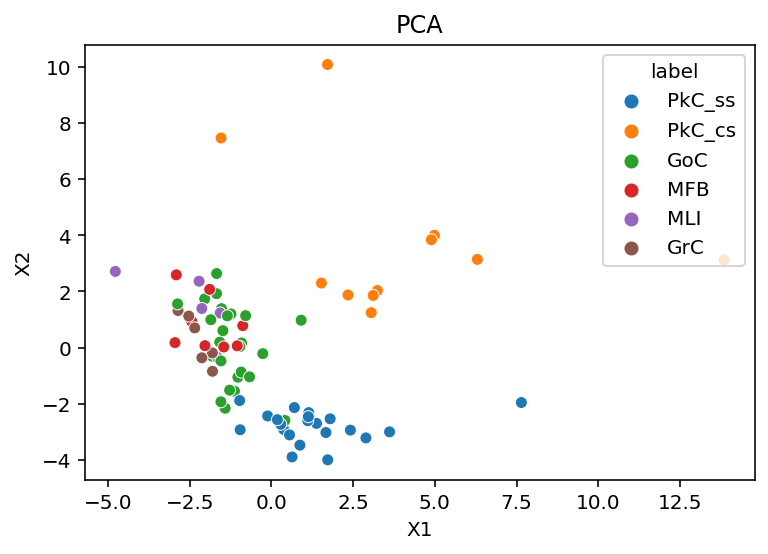

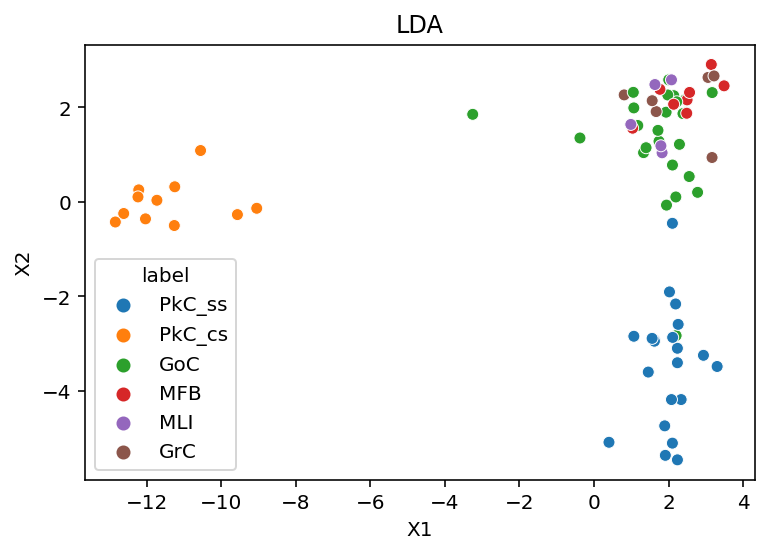

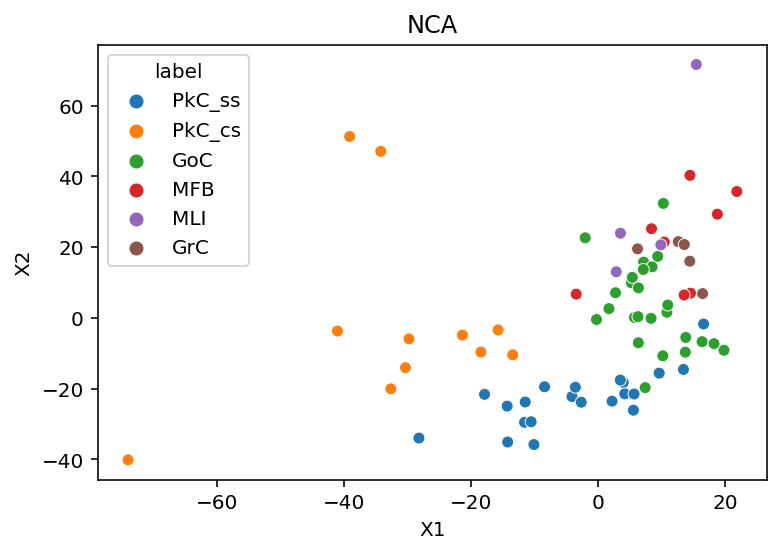

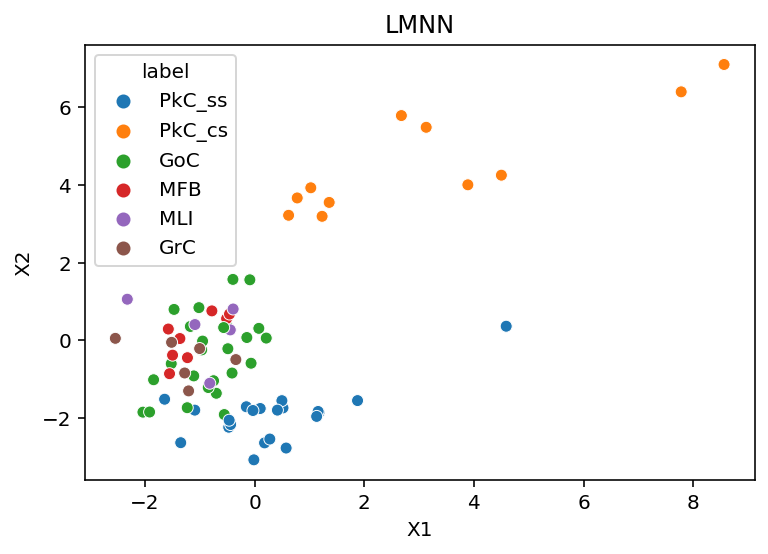

In [ ]:
n_neighbors = 3
random_state = SEED
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Reduce dimension to 2 with Large Margin Nearest Neighbors
lmnn = make_pipeline(
    StandardScaler(),
    LMNN(n_neighbors=n_neighbors, max_iter=3, n_components=2),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca), ("LMNN", lmnn)]


for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X, y)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)
    
    # Do some transforms to plot better with seaborn
    y_plot = pd.Series(y.copy()).replace(to_replace = CORRESPONDENCE).to_numpy()[:, None]
    plotting_data = np.concatenate((X_embedded, y_plot), axis = 1)
    plotting_df = pd.DataFrame(plotting_data, columns = ['X1', 'X2', 'label'])
    
    
    # Plot the projected points and show the evaluation score
    sns.scatterplot(data = plotting_df, x = 'X1', y = 'X2', hue = 'label')
    plt.title(
        "{}".format(name)
    )
plt.show()

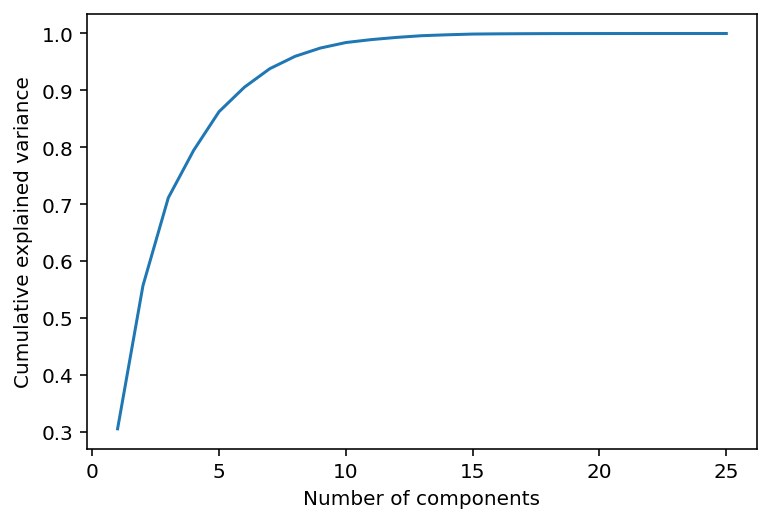

In [ ]:
pca_full = PCA()

X_scaled = StandardScaler().fit_transform(X)

pca_full.fit(X_scaled)

exp_var_cumul = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

# Embeddings

In [ ]:
import umap
import seaborn as sns

In [ ]:
embedding = umap.UMAP(n_neighbors=10, n_components=2, metric='euclidean', random_state=SEED).fit_transform(X)

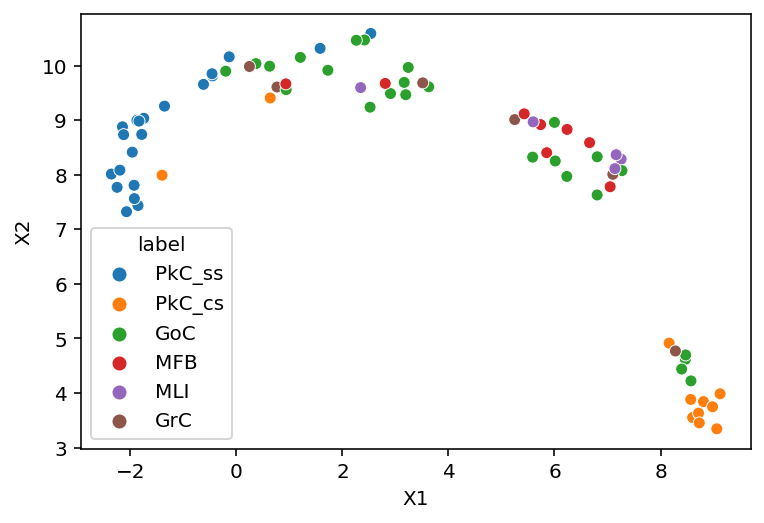

In [ ]:
y_plot = pd.Series(y.copy()).replace(to_replace = CORRESPONDENCE).to_numpy()[:, None]
plotting_data = np.concatenate((embedding, y_plot), axis = 1)
plotting_df = pd.DataFrame(plotting_data, columns = ['X1', 'X2', 'label'])


# Plot the projected points and show the evaluation score
sns.scatterplot(data = plotting_df, x = 'X1', y = 'X2', hue = 'label');